In [ ]:
#Creation and optimization of the single-strain model (4.2.1)

In [1]:
import cobra
import numpy as np
import random as rd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.models import load_model, clone_model
import math
import pickle
import os
import time
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


In [2]:
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

def metabolites_idlist(mets):
    '''Return a list with the metabolites
    '''
    ms=[]
    for m in mets:
        ms.append(m.id)
    return ms

def build_model_matrix(model):
    '''Build a matrix with the metabolites as rows and the reactions in columns
    with the stechiometric values
    '''
    idList = metabolites_idlist(model.metabolites)
    mat=[]
    for react in model.reactions:
        sp_react = react.reaction.split()
        stechs = [0]*len(idList)
        neg=-1
        num=1
        for ele in sp_react:
            if ele in idList:
                #It's an element
                idx = idList.index(ele)
                stechs[idx] = num*neg 
            elif ele in ['-->', '<=>']:
                neg=1
            elif ele == '+':
                num=1
            elif isfloat(ele):
                num=float(ele)
        mat.append(stechs)
    mat=np.array(mat)
    mat.transpose()
    return mat

In [3]:
def define_medium(model, metabolites):
    '''Define the concentration (fluxes) of the metabolites in the medium
    '''
    with model:
        medium = model.medium
        for metab in metabolites:
            medium[metab] = metabolites[metab]
        model.medium = medium
        model.slim_optimize()
        print(model.summary())
    return medium

def user_medium(model):
    '''Inputs for the user to define the metabolites of the medium
    '''
    with model:
        medium = model.medium
        for exch in model.exchanges:
            if exch.reaction.split()[-1] == '<=>':
                user=input('Flux for metabolite {}: '.format(exch.name))
                if isfloat(user):
                    medium[exch.id] = float(user)
        model.medium = medium
        nmodel=model.copy()
    return nmodel

def check_fluxes(model):
    '''Print the non zero in and out fluxes os a metabolism optimized by FBA
    '''
    model.optimize()
    influxes, outfluxes = [],[]
    for exch in model.exchanges:
        if exch.flux > 0:
            outfluxes.append(exch)
        elif exch.flux < 0:
            influxes.append(exch)

    print('In fluxes')
    for exch in influxes:
        print(exch.id,':\t', exch.flux)

    print('\nOut fluxes')
    for exch in outfluxes:
        print(exch.id,':\t', exch.flux)

def get_fluxesIds(m):
    '''Return the metabolites that are exchanged in and out of the cell
    '''
    fluxes = []
    for exch in m.exchanges:
        fluxes.append(exch.id)
    fluxes.append('Biomass')
    return fluxes

def get_fluxes(m):
    '''Return the metabolites that are exchanged in and out of the cell
    '''
    fluxes = {}
    for exch in m.exchanges:
        fluxes[exch.id] = exch.flux
    return fluxes

def compare_fluxes_metabs(m1, m2):
    '''Print the different exchange metabolites between 2 metabolism models
    '''
    set1 = set(get_fluxes(m1))
    set2 = set(get_fluxes(m2))
    return set1.symmetric_difference(set2)

def get_influxesIds(m):
    '''Returns a set with the metabolites that can be taken by the cell
    '''
    influxes = []
    for exch in m.exchanges:
        if exch.reaction.split()[-1] == '<=>':
            influxes.append(exch.id)
    if 'EX_h2o_e' in influxes:
        influxes.remove('EX_h2o_e')
    return influxes

def compare_influxes(m1,m2):
    set1 = set(get_influxes(m1))
    set2 = set(get_influxes(m2))
    return set1.symmetric_difference(set2)

In [4]:
def random_medium(model, mini=0.0, maxi=1000):
    '''Return a dictionary with random values for the metabolites ina  medium
    '''
    medium={}
    inputIds = get_influxesIds(model)
    for metab in inputIds:
        medium[metab] = rd.uniform(mini, maxi)
    return medium

def FBA_output_fluxes(model, medium):
    '''Returns the exchanged fluxes and the biomass with FBA
    '''
    with model:
        model.medium = medium
        biomass=model.slim_optimize()
        if math.isnan(biomass):
            return None
        #print(model.summary())
        fluxes = get_fluxes(model)
        fluxes['biomass'] = biomass
    return fluxes

def dics_to_dicOfLists(dics):
    ndic = {}
    for dic in dics:
        for key in dic:
            if key in ndic:
                ndic[key].append(dic[key])
            else:
                ndic[key] = [dic[key]]
    return ndic

def batch_of_FBAs(model, num=100, maxi=1000):
    '''Returns two lists with the dictionaries of mediums and fluxes
    '''
    all_mediums = []
    all_fluxes = []
    i=0
    t0=time.time()
    while i<num:
        cur_medium = random_medium(model, maxi=maxi)
        cur_fluxes = FBA_output_fluxes(model, cur_medium)
        if not cur_fluxes == None:
            if i%(num/10)==0:
                print('Created {}/{}'.format(i,num))
            all_mediums.append(cur_medium)
            all_fluxes.append(cur_fluxes)
            i+=1
    print('Total time: ',time.time()-t0)
    all_mediums = dics_to_dicOfLists(all_mediums)
    all_fluxes = dics_to_dicOfLists(all_fluxes)
    print('Created {}/{}'.format(num,num))
    return all_mediums, all_fluxes

def build_sets(mediums, fluxes):
    '''Returns two lists of inputs and outputs as lists of lists'''
    inputs, outputs = [], []
    for metab in mediums:
        inputs.append(mediums[metab])
    for metab in fluxes:
        outputs.append(fluxes[metab])
    inputs, outputs = np.array(inputs).T, np.array(outputs).T
    return inputs, outputs

def pickle_save(data,filebase, append=False):
    inputs, outputs = data
    infn, outfn = filebase + '_inputs.pickle', filebase + '_outputs.pickle'
    if infn in os.listdir() or outfn in os.listdir():
        if append:
            preinp, preout = pickle_load(infn, outfn)
            inputs = np.append(preinp,inputs,axis=0)
            outputs = np.append(preout,outputs,axis=0)
            with open(infn, 'wb') as handle:
                pickle.dump(inputs, handle)
            with open(outfn, 'wb') as handle:
                pickle.dump(outputs, handle)
            return
        else:
            filebase += '_2'
    with open(infn, 'wb') as handle:
        pickle.dump(inputs, handle)
    with open(outfn, 'wb') as handle:
        pickle.dump(outputs, handle)

def pickle_load(infn, outfn):
    with open(infn,'rb') as finputs:
        inputs = pickle.load(finputs)
    with open(outfn, 'rb') as foutputs:
        outputs = pickle.load(foutputs)
    return inputs, outputs

def mean_square_error(a,b):
    '''Mean square error between two list numpy arrays'''
    return np.square(a-b).mean()

def mean_absolute_error(a,b):
    '''Mean absolute error between two list numpy arrays'''
    return np.abs(a-b).mean()

def divide_set(s, train_prop, val_prop):
    '''Return the set divided in training, validationa and test sets'''
    val_prop = train_prop + val_prop
    x_train, x_val, x_test = s[:int(train_prop*s.shape[0])], s[int(train_prop*s.shape[0]):int(val_prop*s.shape[0])], s[int(val_prop*s.shape[0]):]
    return x_train, x_val, x_test

def shuffle_dataset(inputs, outputs):
    '''Randomly shuffles the databaset inputs and outputs with the same order (their rows are shuffled)'''
    s= np.arange(inputs.shape[0])
    np.random.shuffle(s)
    return inputs[s,:], outputs[s,:]

def crossvalidationSets(inputs, ncv, j):
    '''Retuns the training and testing subset of the set (inputs) for the ncv-folds crossvalidation
    in the iteration j'''
    xtest = inputs[int(n/ncv*j):int(n/ncv*j+n/ncv),:]
    xtrain1 = inputs[:int(n/ncv*j),:]
    xtrain2 = inputs[int(n/ncv*j+n/ncv):,:]
    xtrain = np.vstack([xtrain1,xtrain2])
    return xtrain, xtest
    

In [20]:
def neural_net_simple(x_train, y_train, x_val, y_val, norm_out=False, nepochs=10, vb=2):
    '''Returns and trains the optimized neural network'''
    ninp, nout = x_train.shape[1], y_train.shape[1]
    model = tf.keras.Sequential()
    model.add(Dense(64, input_shape=(ninp,), activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    if norm_out:
        model.add(Dense(nout, activation='sigmoid'))
    else:
        model.add(Dense(nout))
    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=["accuracy",'mae'])

    history = model.fit(x_train, y_train, epochs=nepochs, verbose=vb , validation_data=(x_val, y_val))
    return history, model

def neural_net_opt(x_train, y_train, nlayers, nneurons, activ, nepochs=10, vb=2, val=False):
    '''Creates and trains a neural network, allowing the introduction of the hyperparameters '''
    ninp, nout = x_train.shape[1], y_train.shape[1]
    model = tf.keras.Sequential()
    model.add(Dense(nneurons[0], input_shape=(ninp,), activation=activ))
    for i in range(1,nlayers):
        model.add(Dense(nneurons[i], activation=activ))
    
    model.add(Dense(nout))
    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
    
    if val==False:
        history = model.fit(x_train, y_train, epochs=nepochs, verbose=vb)
    else:
        history = model.fit(x_train, y_train, epochs=nepochs, verbose=vb , validation_data=(val[0], val[1]))
    return history, model

def neural_net(x_train, y_train, x_val, y_val, nepochs=20, vb=2):
    '''Neural network with batch normalization'''
    ninp, nout = x_train.shape[1], y_train.shape[1]
    model = tf.keras.Sequential()
    model.add(Dense(40, input_shape=(ninp,)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nout))
    
    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=["accuracy",'mae'])
    history = model.fit(x_train, y_train, epochs=nepochs, verbose=vb , validation_data=(x_val, y_val))
    return history, model

def plot_output(history, model):
    # PLOT LOSS AND ACCURACY
    %matplotlib inline
    #-----------------------------------------------------------
    # Retrieve a list of list results on training and test data sets for each training epoch
    #-----------------------------------------------------------
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(len(loss)) # Get number of epochs

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r', label="Training Loss")
    plt.plot(epochs, val_loss, 'b', label="Validation Loss")
    plt.legend(loc='upper right')

    plt.title('Training and validation loss')
    plt.show()
    
def plot_outputNoVal(history, model):
    # PLOT LOSS AND ACCURACY
    %matplotlib inline
    #-----------------------------------------------------------
    # Retrieve a list of list results on training and test data sets for each training epoch
    #-----------------------------------------------------------
    loss=history.history['loss']
    epochs=range(len(loss)) # Get number of epochs

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r', label="Training Loss")
    plt.legend(loc='upper right')

    plt.title('Training and validation loss')
    plt.show()
    
    
def error_rates(pred, test):
    '''Returns the error rates as abs(pred-test) / absavg(pred,test)'''
    diff = np.abs(pred-test)
    absavg = np.abs((pred+test)/2)
    absavg[np.where(absavg==0)]=0.00000001
    return np.sum(diff/absavg, axis=0)

def mean_absolute_error(a,b):
    '''Mean squared error between two list numpy arrays'''
    return np.abs(a-b).mean()

def copyKerasModel(model):
    '''Return a deep copy of a keras model'''
    model_copy=clone_model(model)
    model_copy.compile(loss='mean_squared_error', optimizer='Adam', metrics=["accuracy",'mae'])
    model_copy.set_weights(model.get_weights())
    return model_copy

In [6]:
def checkEqual(iterator):
    '''Check if all values in a vector are equal'''
    return len(set(iterator)) <= 1

def nonzeroidx_output(output, limit = 0.01):
    '''Find the metabolites that change for all the dataset. A metabolite is considered not to change if its values
    are 0 for more than (1-limit) proportion'''
    nonzero = limit*output.shape[0]
    nonzeros_idx=[]
    for j in range(output.shape[1]):
        cur_nonzeros = len(np.where(abs(output[:,j])>0.001)[0])
        if cur_nonzeros > nonzero and not checkEqual(output[:,j]):
            nonzeros_idx.append(j)
    return nonzeros_idx

#Normalize the outputs
def norm_outputs(outputs, incr=0):
    '''Normalize the outputs as (X-min)/(max-min)
    The range can be increased a % over the maximum and minimum so the predictions can excede the 
    dataset values'''
    mins = np.min(outputs,axis=0) - np.abs(np.min(outputs, axis=0)*incr)
    maxs = np.max(outputs,axis=0) + np.abs(np.max(outputs, axis=0)*incr)
    return (outputs-mins) / (maxs-mins), maxs, mins

def norm2real(predictions,maxs,mins):
    '''Return the denormalized values of the output'''
    return predictions * (maxs-mins) + mins

def real2norm(predictions, maxs, mins):
    '''Return the normalized values of the output (with predefined maxs and mins)'''
    return (predictions-mins) / (maxs-mins)
    
def plot_prediction_comparison(prediction, real, metab, save=False):
    '''Plot an histogram with the real and predicted values overlapped'''
    maxi=100
    if len(prediction) > maxi:
        prediction=prediction[:maxi]
        real=real[:maxi]
    
    bins = list(range(len(real)))
    x, y = zip(*sorted(zip(real, prediction)))

    plt.scatter(bins, x, alpha=0.5, label='Real')
    plt.scatter(bins, y, alpha=0.5, label='Prediction')
    plt.legend(loc='upper left')
    plt.title('Metabolite: {}'.format(metab))
    plt.xlabel('Instances')
    plt.ylabel('Fluxes')
    if save!=False:
        plt.savefig('images/{}_{}.jpg'.format(save,metab))
    plt.show()

In [7]:
def dataset2dic(inputs, outputs, FBAmodel, numberFBAs, strain=-1):
    '''Returns the input, output as dictionaries with the ids of the metabolites as keys'''
    inps, outs = {}, {}
    medium_metabs = get_influxesIds(FBAmodel)
    fluxes_metabs = get_fluxesIds(FBAmodel)
    for i in range(len(medium_metabs)):
        inps[medium_metabs[i]] = list(inputs[:numberFBAs,i])
    if strain!=-1:
        inps['strain'] = [strain] * numberFBAs
    for i in range(len(fluxes_metabs)):
        outs[fluxes_metabs[i]] = list(outputs[:numberFBAs,i])
    return inps, outs

def addMetab2dic(metab, dic):
    '''Add a metabolite to the dic that was not present before, filling with zeros that metabolite in the previous indivs'''
    leni=0
    if dic != {}:
        cur_len = len(dic[list(dic.keys())[0]])
    dic[metab] = [0] * leni
    return dic

def addDicIndivs(cur_dic, total_dic, addNew=True):
    '''Add the data in the cur_dic into the total_dic
    Metabs in the toal_dic that are not found in cur_dic are filled with 0s for this cur_dic individuals
    Metabs in the cur_dic that are not found in the total_dic are added filling with 0s for the previous individuals (addMetab2dic)'''
    ninds = len(cur_dic[list(cur_dic.keys())[0]])
    zero_metabs=[]
    for metab in total_dic:
        if metab in cur_dic:
            total_dic[metab] += cur_dic[metab]
        else:
            zero_metabs.append(metab)
            total_dic[metab] += [0]*ninds
    if addNew:
        for metab in cur_dic:
            if not metab in total_dic:
                total_dic = addMetab2dic(metab,total_dic)
                total_dic[metab] += cur_dic[metab]
    return total_dic

def dic2array(dic):
    '''Return an array that is complementary to the dictionary and the keys of the dictionary'''
    data = []
    for metab in dic:
        data.append(np.array(dic[metab]))
    data = np.array(data).T
    return data, list(dic.keys())

def reorder_data(tmetabs, nmetabs, ndata):
    '''Reorder the data (input or output) in the order of tmetab, when the data columns are in nmetabs order'''
    idxs=[]
    for ia in tmetabs:
        idxs.append(nmetabs.index(ia))
    return ndata[:,idxs], np.array(nmetabs)[idxs]

def reorder_data2(tmetabs, nmetabs, ndata):
    '''Reorder the data (input or output) in the order of tmetab, when the data columns are in nmetabs order'''
    idxs=[]
    for ia in tmetabs:
        if ia in nmetabs:
            idxs.append(nmetabs.index(ia))
        else:
            ndata = addColumn(ndata, 0)
            nmetabs.append(ia)
            idxs.append(ndata.shape[1]-1)
    return ndata[:,idxs], np.array(nmetabs)[idxs]

def addColumn(inputs, number=0):
    '''Add a column to the inputs which represents the strain number'''
    return np.vstack((inputs.T, [number]*inputs.shape[0])).T

def emptyDic(dic):
    '''Return an empty dic maintaining the keys'''
    ndic={}
    for k in dic:
        ndic[k]=[]
    return ndic

def biomassIndex(fluxes_metabs):
    '''Returns the index of the biomass'''
    for i in range(len(fluxes_metabs)):
        if 'BIOMASS' in fluxes_metabs[i].upper():
            return i

In [8]:
#Loads the cobra models
dataFolder = 'modelsEC/'
modelBases = ['iJO1366']
modelFns, dataBases, models = [], [], []
for ib in modelBases:
    modelFns.append(ib+'.json')
    dataBases.append('FBAs_{}_random'.format(ib))
    models.append(cobra.io.load_json_model(dataFolder+ib+'.json'))

print(models)
#modMatrix = build_model_matrix(model)

[<Model iJO1366 at 0x1fa466c5f60>]


In [9]:
#Load the isntances of the cobra models
number_of_FBAs = 20000
append=False
maxi_metab = 1000
#Load one model or all
all_models=True

if not all_models:
    idx=0
    database = dataBases[idx]
    print('Loading model: ',database)
    FBAmodel = models[idx]
    premade_FBA = [database+'_inputs.pickle', database+'_outputs.pickle']
    medium_metabs = get_influxesIds(FBAmodel)
    fluxes_metabs_raw = get_fluxesIds(FBAmodel)
    if not append and premade_FBA[0] in os.listdir() and premade_FBA[1] in os.listdir():
        inputs, outputs = pickle_load(premade_FBA[0], premade_FBA[1])
    else:
        all_mediums, all_fluxes = batch_of_FBAs(FBAmodel, number_of_FBAs, maxi = maxi_metab)
        inputs, outputs = build_sets(all_mediums, all_fluxes)
        pickle_save([inputs, outputs], database, append)
        if append:
            inputs, outputs = pickle_load(premade_FBA[0], premade_FBA[1])
    ori_outputs=outputs.copy()
else:
    #Loading all models in the same dataset
    inputs_dic, outputs_dic = {}, {}
    strain=0
    for imodel in range(len(models)):
        database = dataBases[imodel]
        FBAmodel = models[imodel]
        premade_FBA = [database+'_inputs.pickle', database+'_outputs.pickle']
        
        cur_inp, cur_out = pickle_load(premade_FBA[0], premade_FBA[1])
        cur_inp_dic, cur_out_dic = dataset2dic(cur_inp, cur_out, FBAmodel, number_of_FBAs)
        inputs_dic, outputs_dic = addDicIndivs(cur_inp_dic, inputs_dic), addDicIndivs(cur_out_dic, outputs_dic)
        strain+=1
    
    inputs, medium_metabs = dic2array(inputs_dic)
    outputs, fluxes_metabs_raw = dic2array(outputs_dic)

inputs, outputs = shuffle_dataset(inputs, outputs)
ori_outputs = outputs.copy()
print('Input shape: ',inputs.shape)
print('Output shape: ',outputs.shape)

Input shape:  (20000, 24)
Output shape:  (20000, 325)


In [10]:
#Filter the output metabolites, only predicted those with considerable change
nonzeros_idx = nonzeroidx_output(ori_outputs, limit = 0.05)
outputs_raw = ori_outputs[:,nonzeros_idx]
fluxes_metabs = np.array(fluxes_metabs_raw)[nonzeros_idx]

#Normalizing the outputs 
outputs, out_maxs, out_mins = norm_outputs(outputs_raw)
inputs = inputs/1000
print('Input shape: ',inputs.shape)
print('Output shape: ',outputs.shape)

Input shape:  (20000, 24)
Output shape:  (20000, 26)


In [12]:
#Creates the training, validation and test sets
train_prop = 0.8
val_prop = 0.1

x_train, x_val, x_test = divide_set(inputs, train_prop, val_prop)
y_train, y_val, y_test = divide_set(outputs, train_prop, val_prop)
y_train_raw, y_val_raw, y_test_raw = divide_set(outputs_raw, train_prop, val_prop)

In [12]:
#Red con output no normalizado
#net_fn = 'Raw_allEC_net.h5'
#redo=True
#if net_fn in os.listdir() and not redo:
#   model_raw = load_model(net_fn)
#else:
 #   history_raw, model_raw = neural_net_simple(x_train,y_train_raw,x_val,y_val_raw,nepochs=10, vb=1)
  #  plot_output(history_raw, model_raw)
    #model_raw.save(net_fn)

In [13]:
#Net training with the normalized output
net_fn = 'Normalized_allEC_net.h5'
redo = True
if net_fn in os.listdir() and not redo:
    model = load_model(net_fn)
else:
    history, model = neural_net_simple(x_train,y_train,x_val,y_val,norm_out=False,nepochs=10, vb=1)
    plot_output(history, model)
    model.save(net_fn)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 16000 samples, validate on 2000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
16000/16000 [==============================] - 2s 111us/sample - loss: 0.0447 - acc: 0.4071 - mean_absolute_error: 0.1488 - val_loss: 0.0165 - val_acc: 0.3830 - val_mean_absolute_error: 0.0926
Epoch 2/10
16000/16000 [==============================] - 1s 59us/sample - loss: 0.0129 - acc: 0.4307 - mean_absolute_error: 0.0760 - val_loss: 0.0101 - val_acc: 0.3865 - val_mean_absolute_error: 0.0642
Epoch 3/10
16000/16000 [==============================] - 1s 79us/sample - loss: 0.0098 - acc: 0.4316 - mean_absolute_error: 0.0597 - val_loss: 0.0085 - val_acc: 0.4740 - val_mean_absolute_error: 0.0532
Epoch 4/10
16000/16000 [==============================] - 1s 55us/sample - loss: 0.0089 - acc: 0.4435 - mean_absolute_error: 0.0544 - val_loss: 0.0079 - val_acc: 0.5155 - va

KeyboardInterrupt: 

In [14]:
#Evaluation of the trained model
bioIdx=biomassIndex(fluxes_metabs)

print('\n# Evaluate on test data (normalized output)')
results = model.evaluate(x_test, y_test)
predictions = model.predict(x_test)
predictions_real = norm2real(predictions, out_maxs, out_mins)
mse = mean_square_error(predictions, y_test)
mae = mean_absolute_error(predictions, y_test)
biom_mae = mean_absolute_error(y_test[:,bioIdx],predictions[:,bioIdx])
print('NORM: test MSE, test MAE, biomass_error:', mse, mae, biom_mae)


# Evaluate on test data (raw output)
2000/2000 [==============================] - 0s 50us/sample - loss: 9906.0313 - acc: 0.7000 - mean_absolute_error: 47.0907
RAW: test MSE, test MAE, biomass_error: 411.0480943766148 5.930237011194393 0.1592900655105946

# Evaluate on test data (normalized output)
2000/2000 [==============================] - 0s 50us/sample - loss: 0.0082 - acc: 0.5675 - mean_absolute_error: 0.0437
NORM: test MSE, test MAE, biomass_error: 0.008248188326323713 0.04370854864337804 0.03700802968121915


In [15]:
t0=time.time()
model.evaluate(x_test, y_test)
tf=time.time()
print('Time per sample (us): {}'.format(10**6*(tf-t0)/x_test.shape[0]))

2000/2000 [==============================] - 0s 39us/sample - loss: 0.0082 - acc: 0.5675 - mean_absolute_error: 0.0437
Time per sample (us): 39.05606269836426


In [44]:
#Optimization if the hyperparametrs 
ncv=10

nlayers = [1,2,3]
layerProbs=2**np.array(nlayers)
nneurons=[16,32,64,128]

try:
    with open('simpleNetOptimization.pickle','rb') as handle:
        results = pickle.load(handle)
    print('Previous results loaded')
except:
    results={}

nnets=50
for i in range(nnets):
    #Choosing the parameters. A combination that has not been used previously
    ic=10
    while ic>0:
        nlay=np.random.choice(nlayers, p=layerProbs/sum(layerProbs))
        nneu=np.random.choice(nneurons, size=nlay)
        acti='relu'
        resultsId = (nlay,tuple(nneu), acti)
        if not resultsId in results:
            break
        ic-=1
    if ic==0:
        break
    
    print('\nNetwork {}/{} with {} layers, {} neurons, {} activation'.format(i+1,nnets,nlay,nneu,acti))
    cur_maes=[]
    npass=4
    for j in range(npass):
        print('CV {}/{}'.format(j+1,npass))
        n=inputs.shape[0]
        xtrain, xtest = crossvalidationSets(inputs, ncv, j)
        ytrain, ytest = crossvalidationSets(outputs, ncv, j)
        hist, model_opt = neural_net_opt(xtrain, ytrain, nlay, nneu, acti, nepochs=10, vb=0)
        
        cur_maes.append(model_opt.evaluate(xtest, ytest,verbose=False)[1])
    #model_opt.summary()
    cur_mae=np.mean(cur_maes)
    print('MAE of the net: ', cur_mae)
    
    results[resultsId]=[cur_mae, model_opt.count_params()]

with open('simpleNetOptimization.pickle', 'wb') as handle:
    pickle.dump(results, handle)

Previous results loaded

Network 1/1 with 3 layers, [32 64 64] neurons, relu activation
CV 1/4
CV 2/4
CV 3/4
CV 4/4
MAE of the net:  0.041177876


In [11]:
#Optimization with the other 2 strains
ncv=10
strain=modelBases[0]

with open('simpleNetOptimization.pickle','rb') as handle:
    prev_results = pickle.load(handle)
with open('simpleNetOptimization{}.pickle'.format(strain),'rb') as handle:
    results = pickle.load(handle)
print('Previous results loaded')

i=len(results)
for k in prev_results:
    if not k in results:
        nlay=k[0]
        nneu=k[1]
        acti=k[2]
        print('\nNetwork {}/{} with {} layers, {} neurons, {} activation'.format(i+1,len(prev_results),nlay,nneu,acti))
        i+=1
        cur_maes=[]
        npass=4
        for j in range(npass):
            print('CV {}/{}'.format(j+1,npass))
            n=inputs.shape[0]
            xtrain, xtest = crossvalidationSets(inputs, ncv, j)
            ytrain, ytest = crossvalidationSets(outputs, ncv, j)
            hist, model_opt = neural_net_opt(xtrain, ytrain, nlay, nneu, acti, nepochs=10, vb=0)

            cur_maes.append(model_opt.evaluate(xtest, ytest,verbose=False)[1])
        #model_opt.summary()
        cur_mae=np.mean(cur_maes)
        print('MAE of the net: ', cur_mae)

        results[k]=[cur_mae, model_opt.count_params()]

with open('simpleNetOptimization{}.pickle'.format(strain), 'wb') as handle:
    pickle.dump(results, handle)

Previous results loaded

Network 41/50 with 2 layers, (128, 32) neurons, relu activation
CV 1/4
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
CV 2/4
CV 3/4
CV 4/4
MAE of the net:  0.049384493

Network 42/50 with 3 layers, (16, 64, 64) neurons, relu activation
CV 1/4
CV 2/4
CV 3/4
CV 4/4
MAE of the net:  0.0406714

Network 43/50 with 2 layers, (128, 16) neurons, relu activation
CV 1/4
CV 2/4
CV 3/4
CV 4/4
MAE of the net:  0.047008377

Network 44/50 with 3 layers, (64, 128, 64) neurons, relu activation
CV 1/4
CV 2/4
CV 3/4
CV 4/4
MAE of the net:  0.039618656

Network 45/50 with 1 layers, (32,) neurons, relu activation
CV 1/4
CV 2/4
CV 3/4
CV 4/4
MAE of the net:  0.05880265

Network 46/50 with 2 layers, (128, 64) neurons, relu activation
CV 1/4
CV 2/4
CV 3/4
CV 4/4
MAE of the net:  0.04233196

Network 47/50 with 3 layers, (32, 32, 16) neurons, relu activation
CV 1/4
CV

In [15]:
#Averaging the results and saving them
results={}
modelBases=['iEC042','iAPECO1','iJO1366']
for strain in modelBases:
    with open('simpleNetOptimization{}.pickle'.format(strain),'rb') as handle:
        resultsLoad = pickle.load(handle)
    for k in resultsLoad:
        if k in results:
            results[k][0]+=resultsLoad[k][0]/3
        else:
            results[k]=[resultsLoad[k][0]/3, resultsLoad[k][1]]

with open('simpleNetOptimizationAll.pickle', 'wb') as handle:
    pickle.dump(results, handle)
{k: v for k, v in sorted(results.items(), key=lambda item: item[1])}

C:\Users\danie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545 UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.


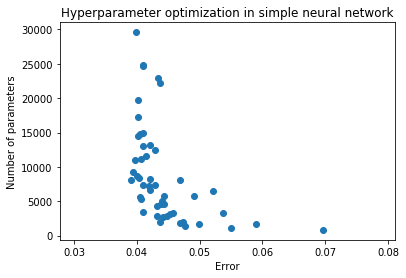

In [17]:
#Plotting the results of the optimization
relus = []
for k in results:
    relus.append(results[k])

relus = np.array(relus)
plt.scatter(relus[:,0], relus[:,1])
plt.xlabel('Error')
plt.legend(loc='upper right')
plt.ylabel('Number of parameters')
plt.title('Hyperparameter optimization in simple neural network')
plt.savefig('images/simpleNetRelu.png')
plt.show()

Train on 18000 samples, validate on 2000 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


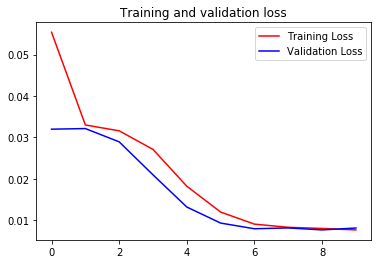

In [120]:
#Getting the neural network with the optimized hyperparameters
hist, model_opt = neural_net_opt(xtrain, ytrain, 4, [256]*4, 'sigmoid', nepochs=10, vb=4, val=[xtest,ytest])
plot_output(hist, model_opt)

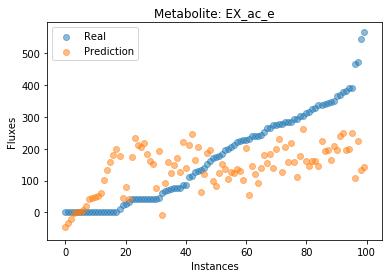

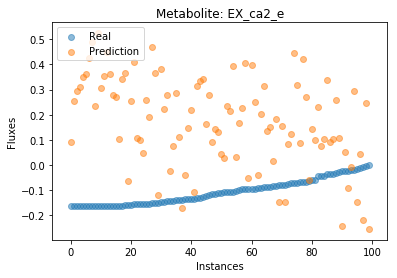

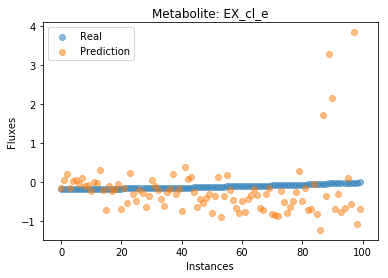

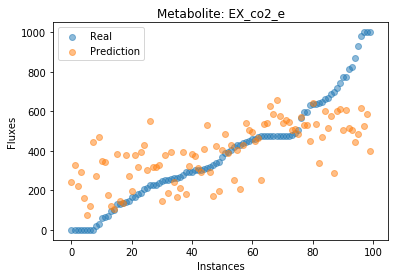

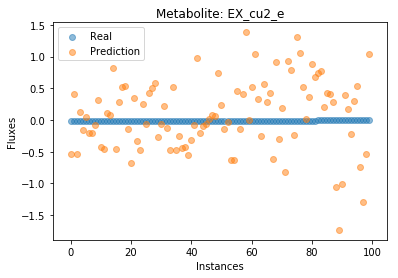

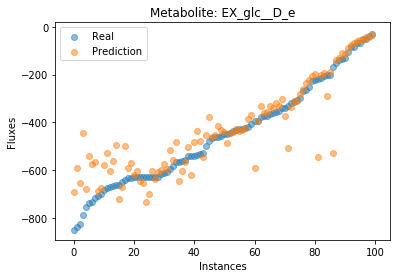

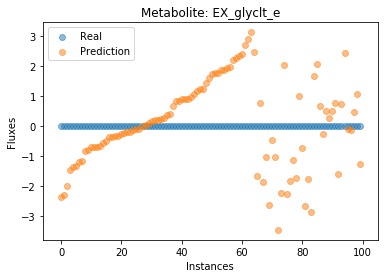

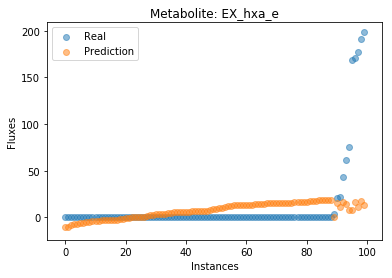

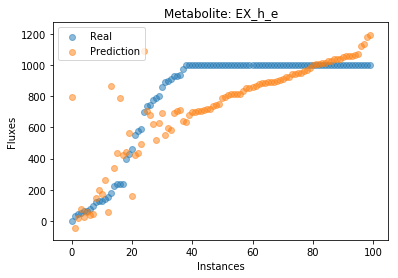

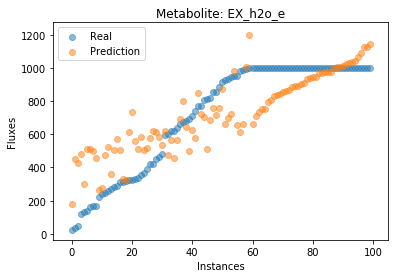

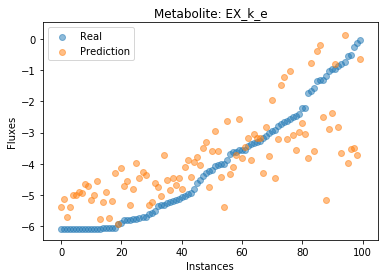

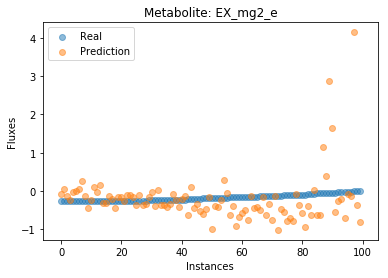

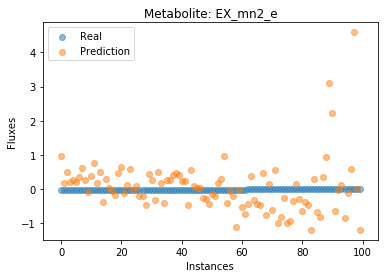

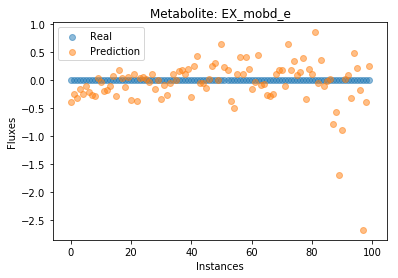

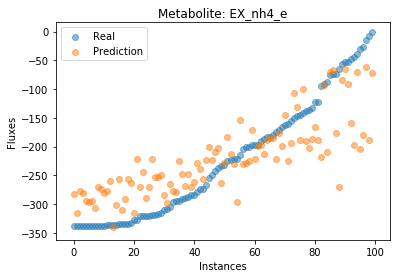

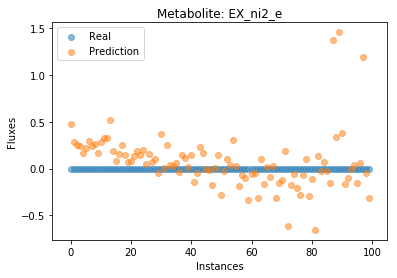

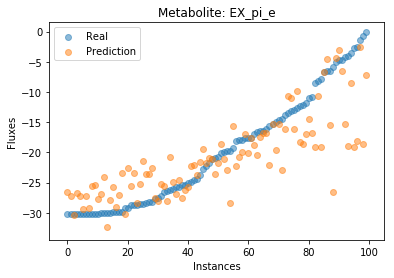

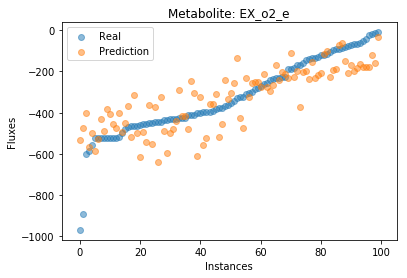

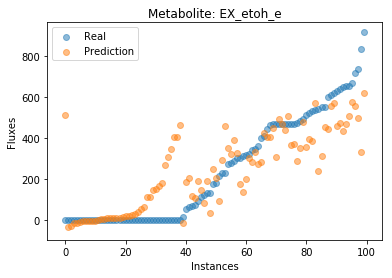

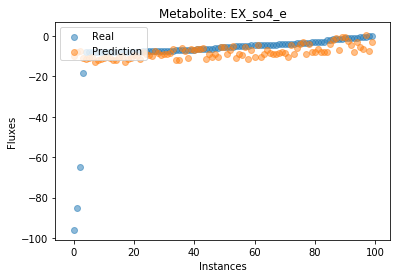

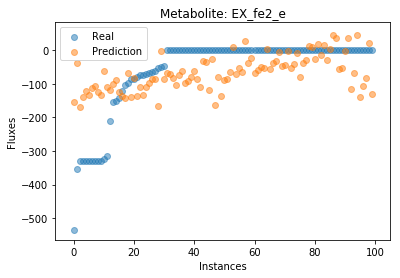

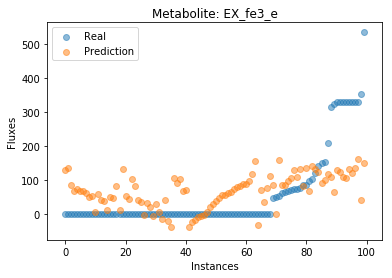

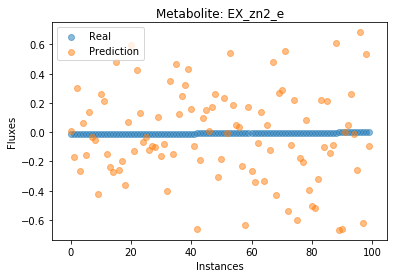

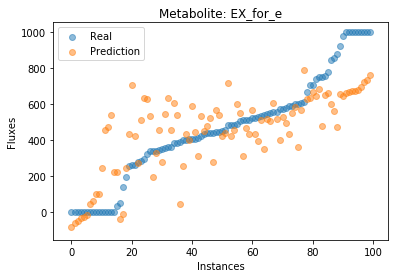

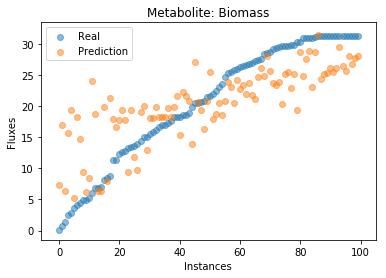

In [55]:
#Visualize raw network results
for idx in range(y_test.shape[1]):
    plot_prediction_comparison(predictions_raw[:100,idx], y_test_raw[:100,idx], fluxes_metabs[idx], 
                               save='Raw_predictions')

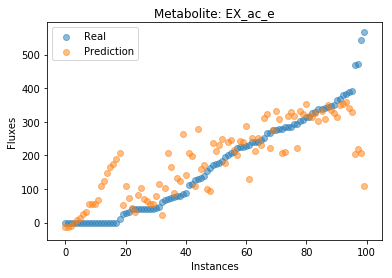

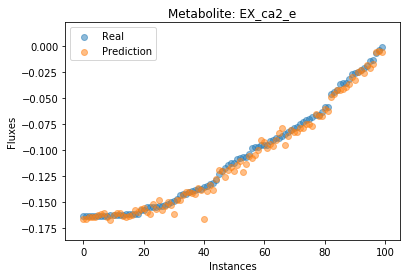

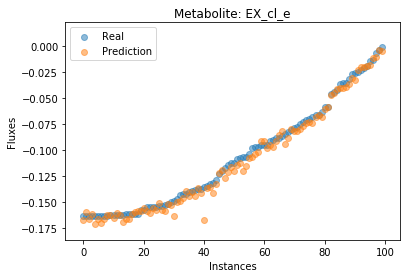

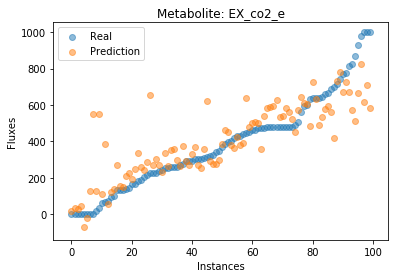

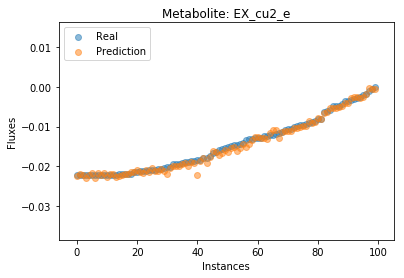

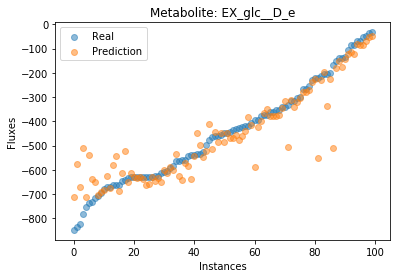

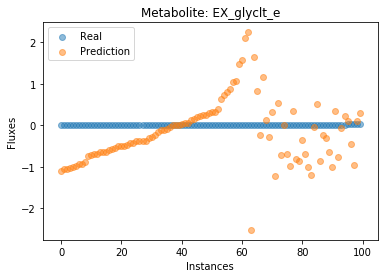

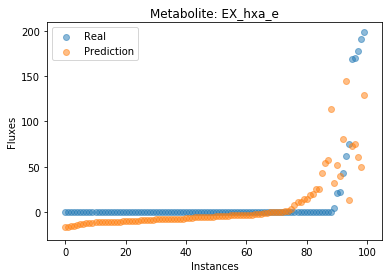

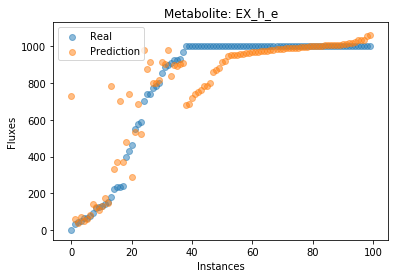

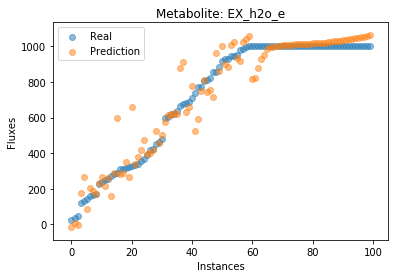

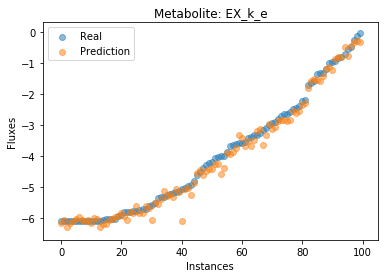

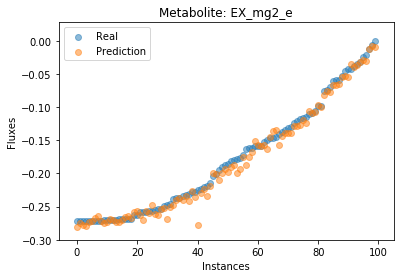

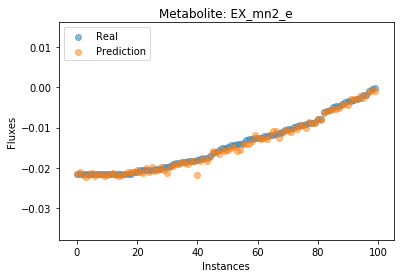

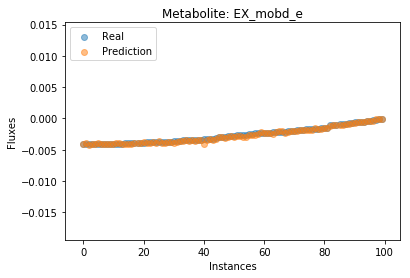

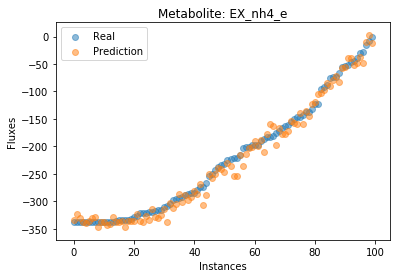

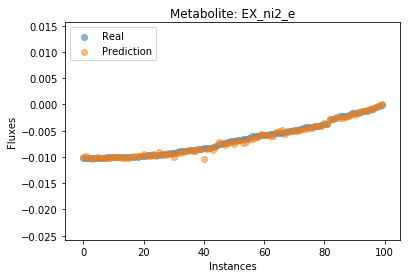

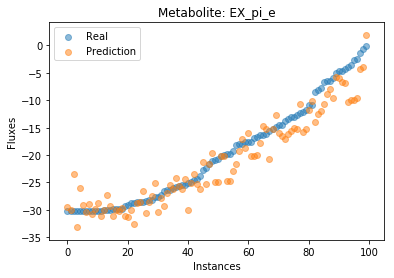

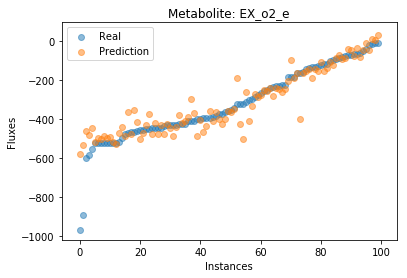

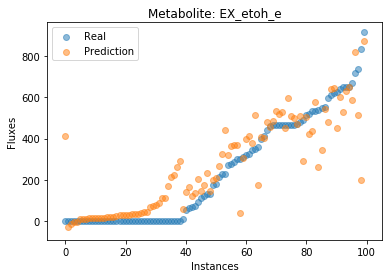

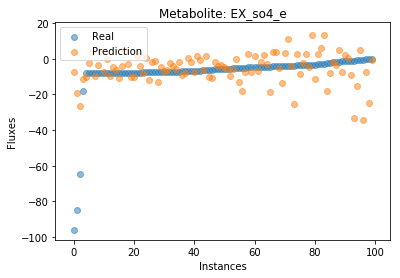

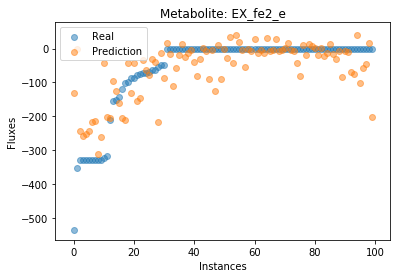

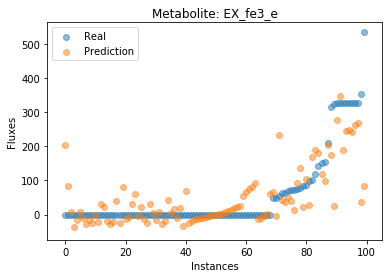

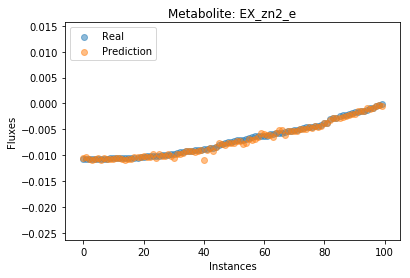

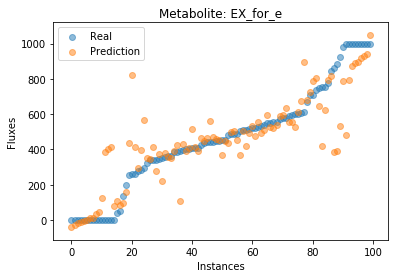

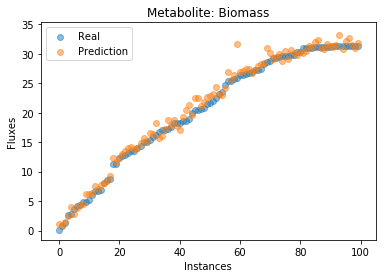

In [56]:
#Visualize norm network results
for idx in range(y_test.shape[1]):
    plot_prediction_comparison(predictions_real[:100,idx], y_test_raw[:100,idx], fluxes_metabs[idx],
                              save='Norm_predictions')

In [55]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions')
predictions = model.predict(x_test)
print('Biomass MAE: ', mean_absolute_error(y_test_raw[:,-1],predictions[:,-1]))

maes = []
for i in range(y_test_raw.shape[1]):
    maes.append(mean_absolute_error(y_test_raw[:,i], predictions[:,i]))
errors=np.where(np.array(maes)>0.05)
print('Fluxes with high error: ',np.array(fluxes_metabs)[errors])


# Generate predictions
Biomass MAE:  19.08245198167044
Fluxes with high error:  ['EX_ac_e' 'EX_ca2_e' 'EX_cl_e' 'EX_co2_e' 'EX_cu2_e' 'EX_glc__D_e'
 'EX_glyclt_e' 'EX_hxa_e' 'EX_h_e' 'EX_h2o_e' 'EX_k_e' 'EX_mg2_e'
 'EX_mn2_e' 'EX_mobd_e' 'EX_nh4_e' 'EX_ni2_e' 'EX_pi_e' 'EX_o2_e'
 'EX_etoh_e' 'EX_so4_e' 'EX_fe2_e' 'EX_fe3_e' 'EX_zn2_e' 'EX_for_e'
 'Biomass']


In [56]:
idx=-1
print('Predictions: ', predictions[:6,errors[0][idx]])
print('Real values: ', y_test_raw[:6,errors[0][idx]])
print(mean_absolute_error(y_test_raw[:,errors[0][idx]], predictions[:,errors[0][idx]]))

Predictions:  [0.08708146 0.22920719 0.19144088 0.7651951  0.5917137  0.6374318 ]
Real values:  [ 0.67364533  7.89012106  7.50282562 31.05254921 21.17455438 24.39098156]
19.08245198167044


In [57]:
#Prueba de la red modelo en otra cepa
strain='iWFL'
dataFolder = 'modelsEC/'
filebase2 = 'FBAs_{}_random'.format(strain)
FBAmodel2 = cobra.io.load_json_model(dataFolder+strain+'.json')
append=False
nFBAs=4000

medium_metabs2 = get_influxesIds(FBAmodel2)
fluxes_metabs2_raw = get_fluxesIds(FBAmodel2)

premade_FBA = [filebase2+'_inputs.pickle', filebase2+'_outputs.pickle']
if not append and premade_FBA[1] in os.listdir() and premade_FBA[1] in os.listdir():
    inputs2, outputs2 = pickle_load(premade_FBA[0], premade_FBA[1])
else:
    all_mediums, all_fluxes = batch_of_FBAs(FBAmodel2, nFBAs, maxi = 1000)
    inputs2, outputs2 = build_sets(all_mediums, all_fluxes)
    pickle_save([inputs2, outputs2], filebase2, append)
    if append:
        inputs2, outputs2 = pickle_load(premade_FBA[0], premade_FBA[1])
        

#Reorder the columns in the same way as the first model
inputs2, medium_metabs2 = reorder_data(medium_metabs, medium_metabs2, inputs2)
outputs2, fluxes_metabs2_raw = reorder_data(fluxes_metabs_raw, fluxes_metabs2_raw, outputs2)

inputs2=inputs2/1000
outputs2 = outputs2[:,nonzeros_idx]
norm_outputs2 = real2norm(outputs2, out_maxs, out_mins)
fluxes_metabs2 = fluxes_metabs2_raw[nonzeros_idx]

print('New model: ', FBAmodel2)
print('Input shape: ',inputs2.shape)
print('Output shape: ',norm_outputs2.shape)

New model:  iWFL_1372
Input shape:  (5000, 24)
Output shape:  (5000, 25)


In [58]:
#outputs2 = outputs2[:,nonzeros_idx]
print('\n# Evaluate on test data (raw output)')
results2 = model.evaluate(inputs2, norm_outputs2)
print('test MSE, test acc, test MAE:', results2)

print('\n# Generate predictions')
predictions2 = model.predict(inputs2)
print('Biomass MSE: ', mean_square_error(norm_outputs2[:,bioIdx],predictions2[:,bioIdx]))


# Evaluate on test data (raw output)
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0055 - acc: 0.9432 - mean_absolute_error: 0.0376
test MSE, test acc, test MAE: [0.005451424827426672, 0.9432, 0.037562773]

# Generate predictions
Biomass MSE:  0.004773995091332274


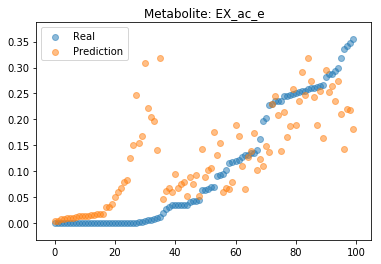

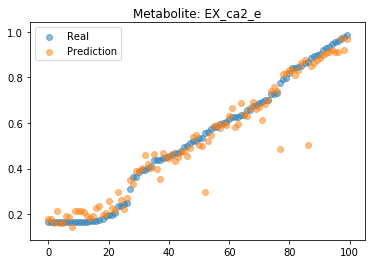

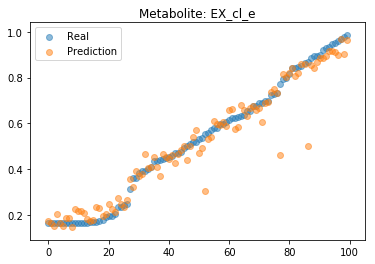

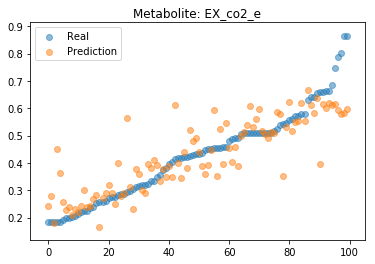

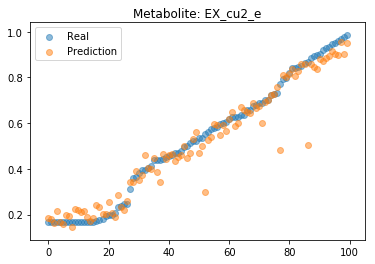

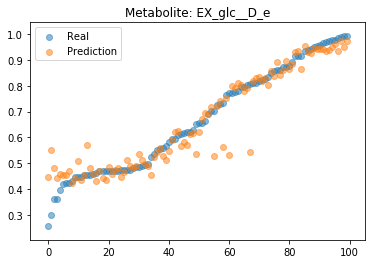

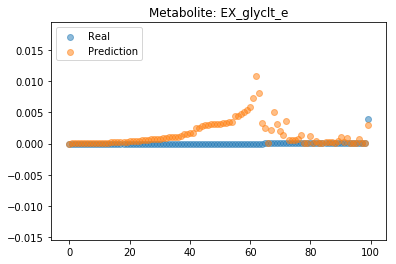

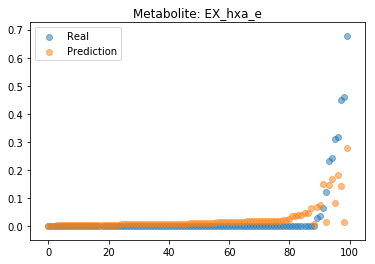

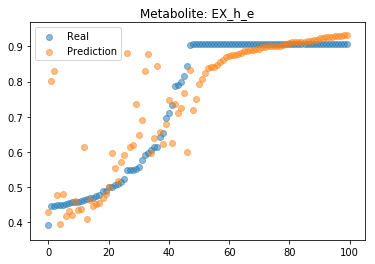

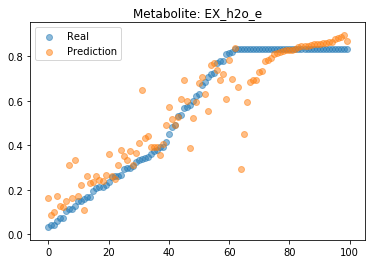

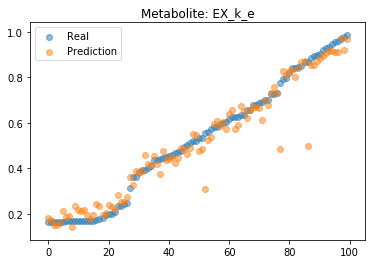

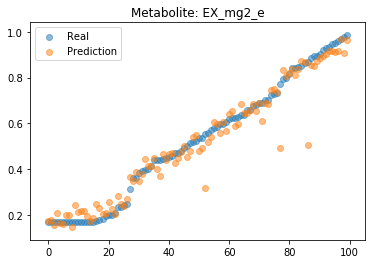

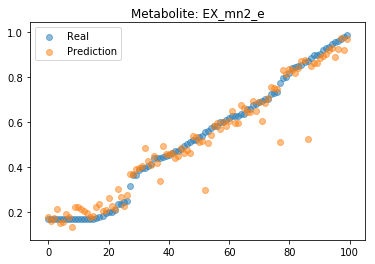

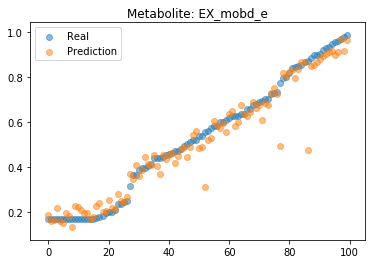

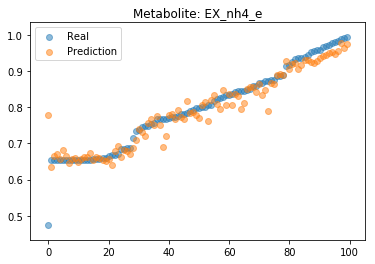

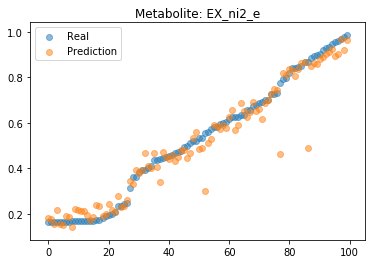

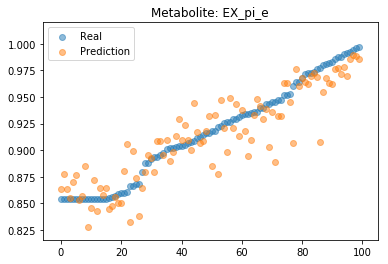

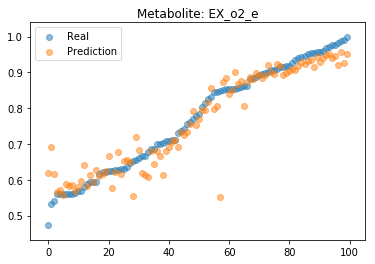

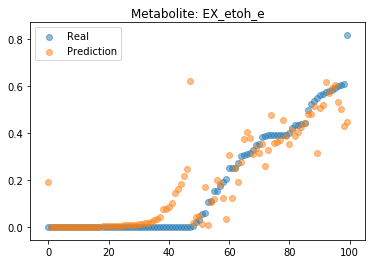

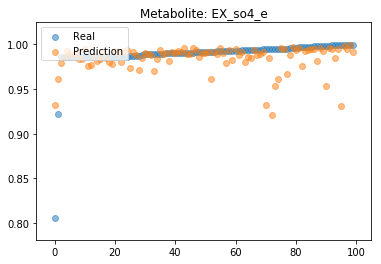

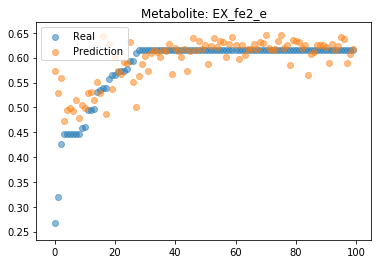

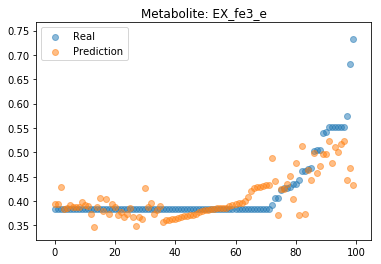

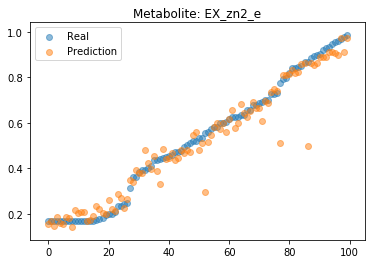

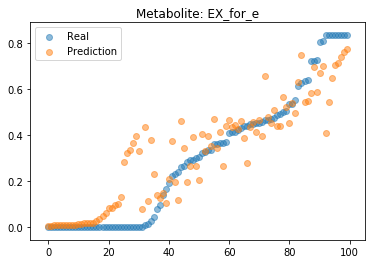

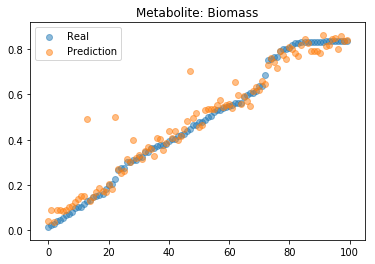

In [59]:
#Visualize other strain network results
for idx in range(norm_outputs2.shape[1]):
    plot_prediction_comparison(predictions2[:100,idx], norm_outputs2[:100,idx], fluxes_metabs[idx])

In [60]:
train_prop = 0.8
val_prop = 0.1

x_train2, x_val2, x_test2 = divide_set(inputs2, train_prop, val_prop)
y_train2, y_val2, y_test2 = divide_set(norm_outputs2, train_prop, val_prop)

In [ ]:
###############################################
# Transfer Learning
####################################

Train on 4000 samples, validate on 500 samples
Epoch 1/5
4000/4000 [==============================] - 1s 232us/sample - loss: 0.0056 - acc: 0.9517 - mean_absolute_error: 0.0391 - val_loss: 0.0057 - val_acc: 0.9600 - val_mean_absolute_error: 0.0432
Epoch 2/5
4000/4000 [==============================] - 0s 71us/sample - loss: 0.0055 - acc: 0.9542 - mean_absolute_error: 0.0392 - val_loss: 0.0057 - val_acc: 0.9520 - val_mean_absolute_error: 0.0438
Epoch 3/5
4000/4000 [==============================] - 0s 65us/sample - loss: 0.0053 - acc: 0.9550 - mean_absolute_error: 0.0375 - val_loss: 0.0053 - val_acc: 0.9600 - val_mean_absolute_error: 0.0365
Epoch 4/5
4000/4000 [==============================] - 0s 65us/sample - loss: 0.0053 - acc: 0.9535 - mean_absolute_error: 0.0373 - val_loss: 0.0053 - val_acc: 0.9560 - val_mean_absolute_error: 0.0368
Epoch 5/5
4000/4000 [==============================] - 0s 68us/sample - loss: 0.0052 - acc: 0.9535 - mean_absolute_error: 0.0369 - val_loss: 0.0053 - va

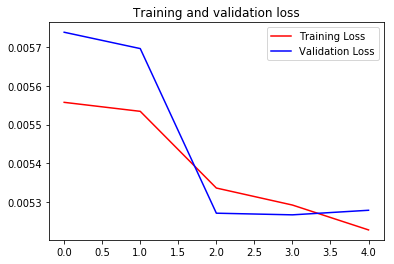

In [61]:
#Copying the model to test the transfer learning
model_transfer =  copyKerasModel(model)
history = model_transfer.fit(x_train2, y_train2, epochs=5, verbose=1 , validation_data=(x_val2, y_val2))
plot_output(history, model_transfer)

In [62]:
#Evaluating the results
print('\n# Evaluate on test data (raw output)')
results2 = model_transfer.evaluate(x_test2, y_test2)
print('test MSE, test acc, test MAE:', results2)

print('\n# Generate predictions')
predictions2 = model_transfer.predict(x_test2)
print('Biomass MAE: ', mean_absolute_error(y_test2[:,bioIdx],predictions2[:,bioIdx]))


# Evaluate on test data (raw output)
500/500 [==============================] - 0s 37us/sample - loss: 0.0059 - acc: 0.9620 - mean_absolute_error: 0.0378
test MSE, test acc, test MAE: [0.0058594119809567925, 0.962, 0.037815653]

# Generate predictions
Biomass MAE:  0.03449136323242839


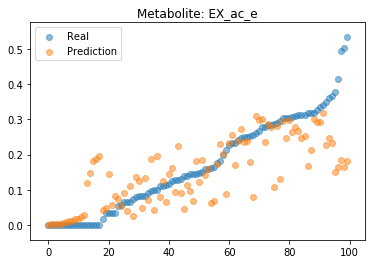

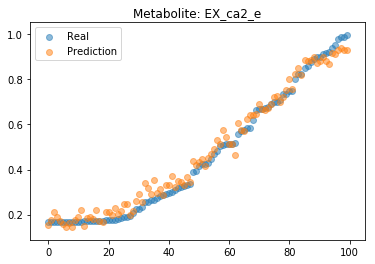

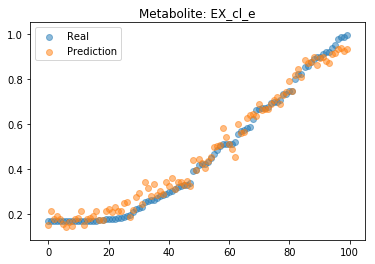

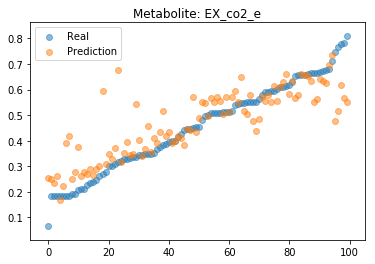

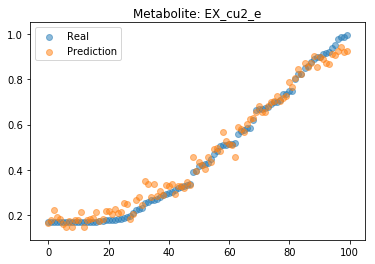

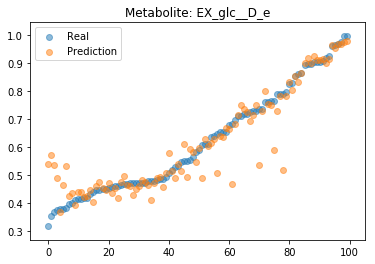

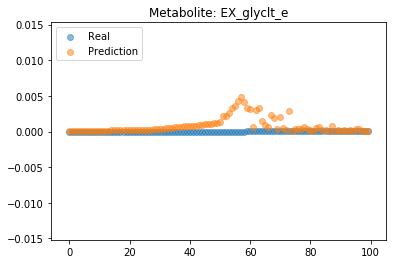

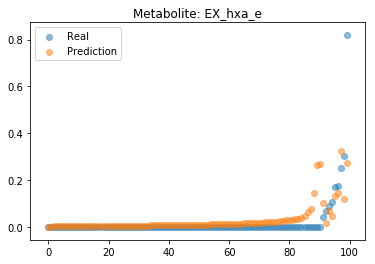

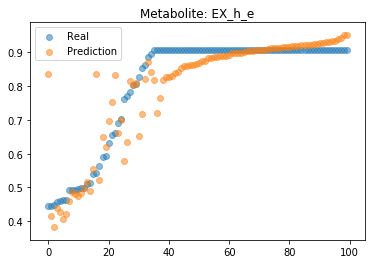

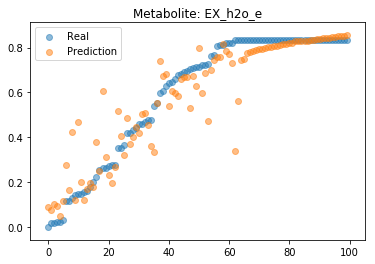

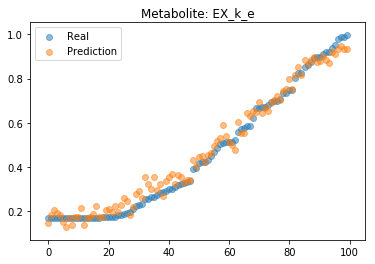

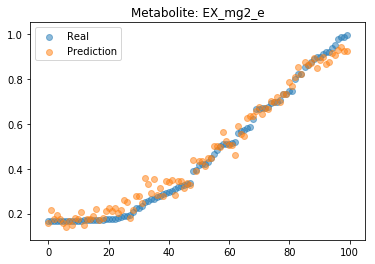

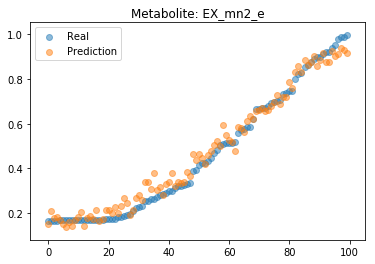

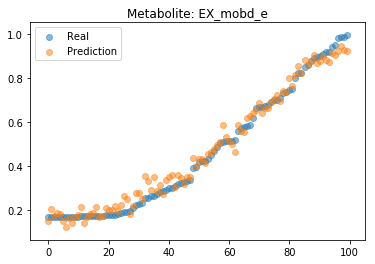

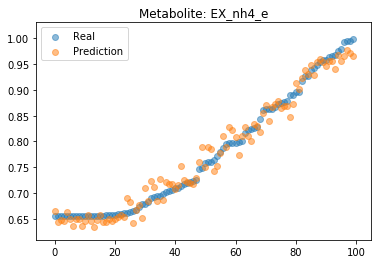

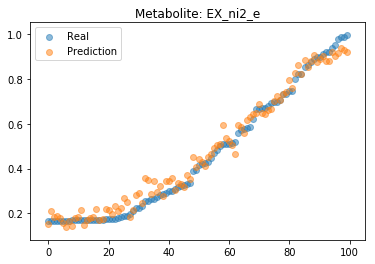

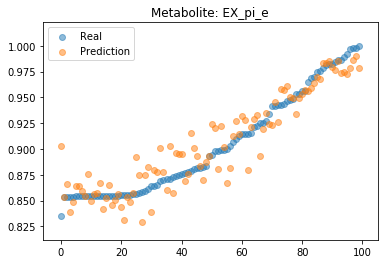

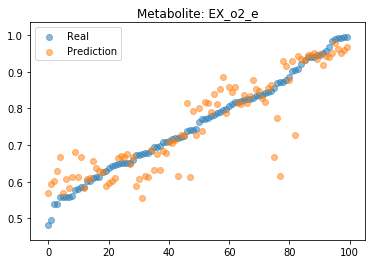

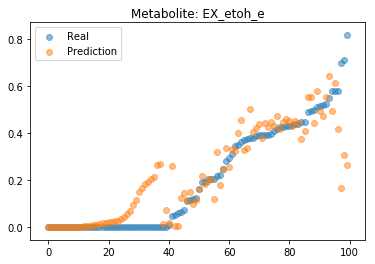

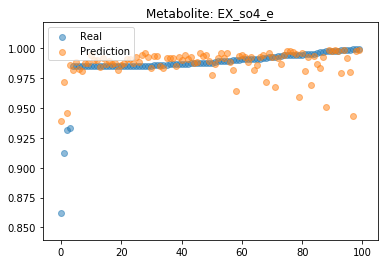

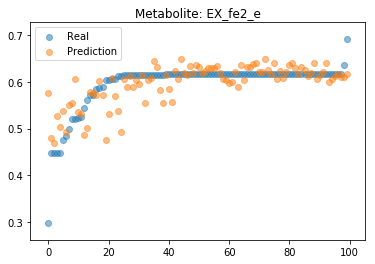

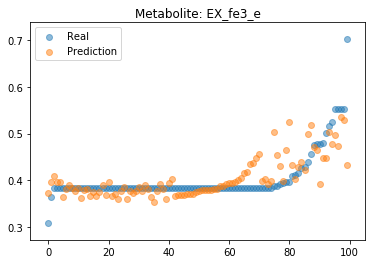

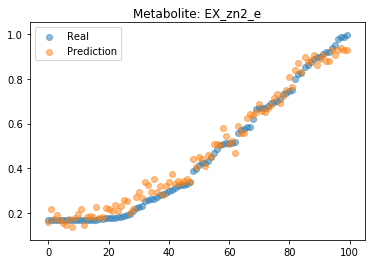

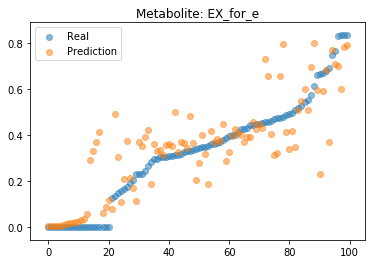

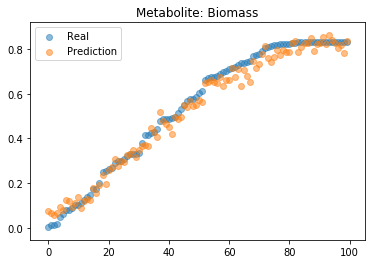

In [63]:
#Visualize other strain network results
for idx in range(norm_outputs2.shape[1]):
    plot_prediction_comparison(predictions2[:100,idx], y_test2[:100,idx], fluxes_metabs[idx])

In [64]:
#Loading the model from Salmonella
modelFnS = 'iYS1720.json'
salm_model = cobra.io.load_json_model('modelsOthers/'+modelFnS)

In [114]:
#Prueba de la red modelo en otra cepa
filebaseS = 'FBAs_iYS1720_random'
append=False
strainS=3
nFBAs = 10000

premade_FBA = [filebaseS+'_inputs.pickle', filebaseS+'_outputs.pickle']
if not append and premade_FBA[1] in os.listdir() and premade_FBA[1] in os.listdir():
    inputsS, outputsS = pickle_load(premade_FBA[0], premade_FBA[1])
else:
    all_mediums, all_fluxes = batch_of_FBAs(salm_model, nFBAs, maxi = 1000)
    inputsS, outputsS = build_sets(all_mediums, all_fluxes)
    pickle_save([inputsS, outputsS], filebaseS, append)
    if append:
        inputsS, outputsS = pickle_load(premade_FBA[0], premade_FBA[1])
nindsS = inputsS.shape[0]

#Take only the desired number of individuals
nFBAsS = min(nFBAs, inputsS.shape[0])
inputsS, outputsS = inputsS[:nFBAs,:], outputsS[:nFBAs,:]

In [115]:
#Modify the dataset for having the same input-output metabolites as the net expectes (0 if they don't exist)
cur_inp_dic, cur_out_dic = dataset2dic(inputsS, outputsS, salm_model, inputsS.shape[0])
#Remove mold individuals from the dataset
inputsS_dic, outputsS_dic = emptyDic(inputs_dic), emptyDic(outputs_dic)
inputs_dic = addDicIndivs(cur_inp_dic, inputsS_dic,False) 
outputs_dic = addDicIndivs(cur_out_dic, outputsS_dic,False)
inputsS, medium_metabsS = dic2array(inputs_dic)
outputsS, fluxes_metabsS_raw = dic2array(outputs_dic)

#Shuffles the rows of the data
inputsS, outputsS = shuffle_dataset(inputsS, outputsS)

#Normalize and remove null outputs
inputsS=inputsS/1000
outputsS = outputsS[:,nonzeros_idx]
norm_outputsS = real2norm(outputsS, out_maxs, out_mins)
fluxes_metabsS = np.array(fluxes_metabsS_raw)[nonzeros_idx]
print('Inputs shape :',inputsS.shape)
print('Outputs shape: ',outputsS.shape)

Inputs shape : (5000, 24)
Outputs shape:  (5000, 25)


In [116]:
print('\n# Evaluate on test data')
resultsS = model.evaluate(inputsS, norm_outputsS)
print('test MSE, test acc, test MAE:', resultsS)

print('\n# Generate predictions')
predictionsS = model.predict(inputsS)
print('Biomass MAE: ', mean_absolute_error(norm_outputsS[:,bioIdx],predictionsS[:,bioIdx]))


# Evaluate on test data
5000/5000 [==============================] - 0s 45us/sample - loss: 0.1221 - acc: 0.0000e+00 - mean_absolute_error: 0.2214
test MSE, test acc, test MAE: [0.12206211404800416, 0.0, 0.22137092]

# Generate predictions
Biomass MAE:  0.03233103246018095


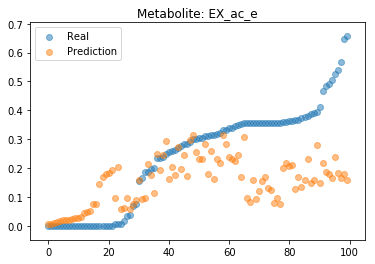

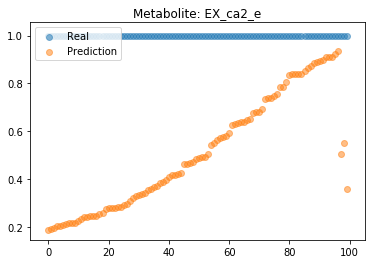

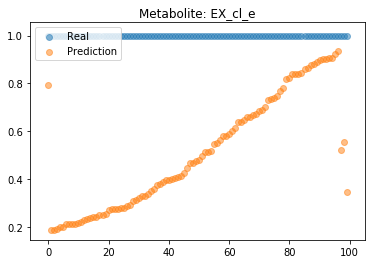

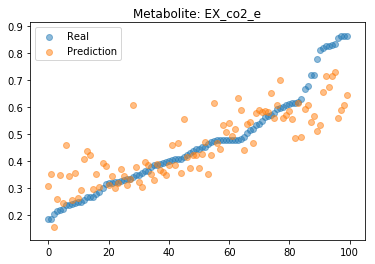

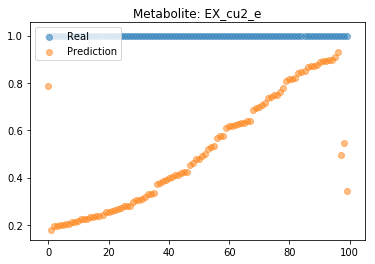

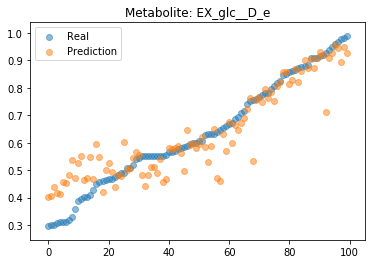

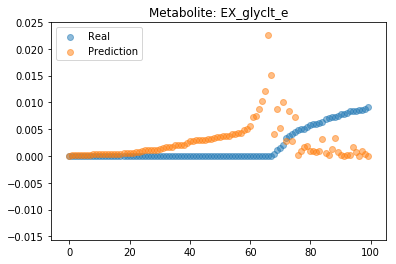

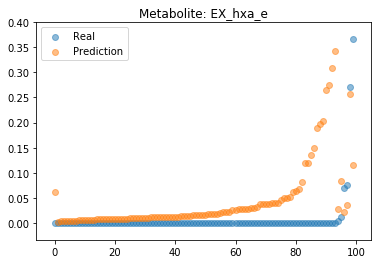

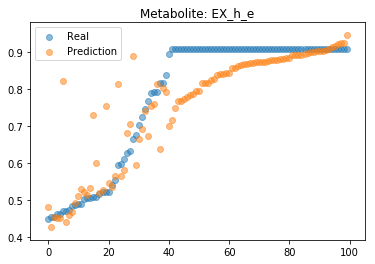

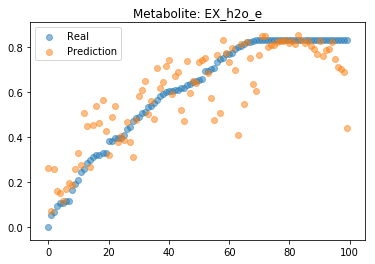

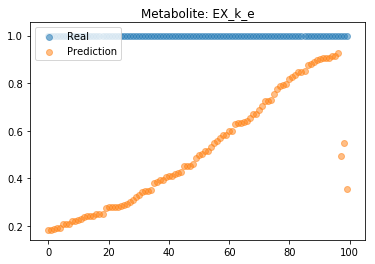

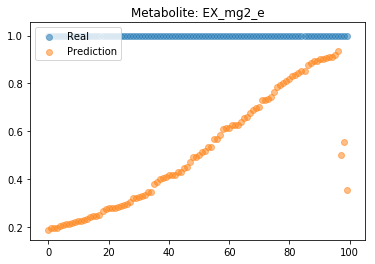

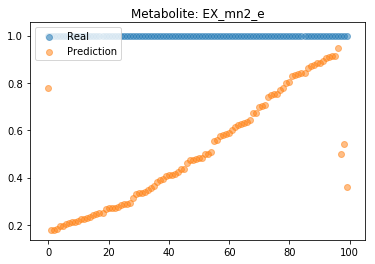

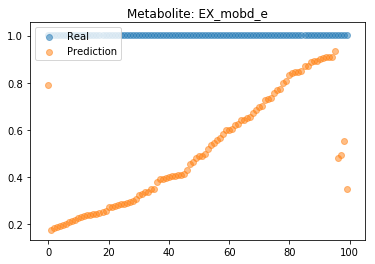

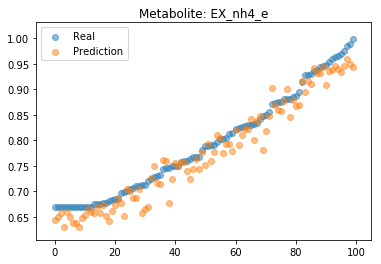

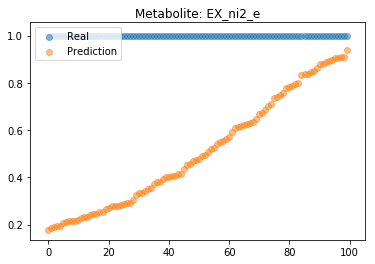

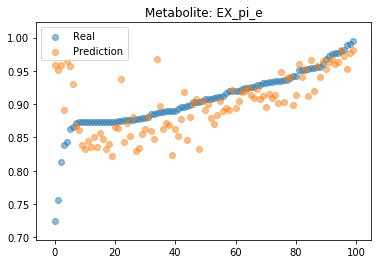

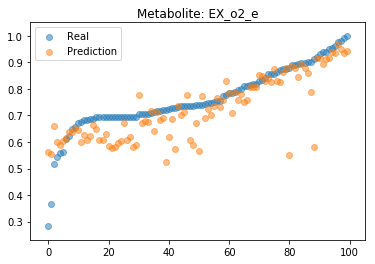

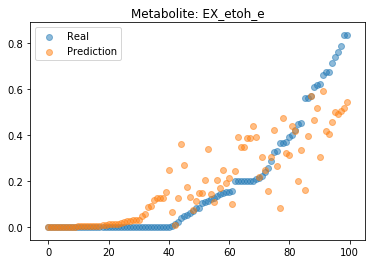

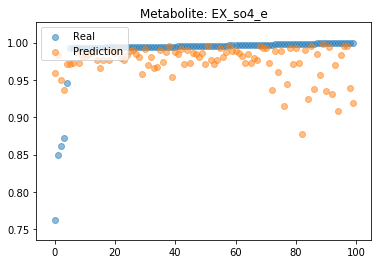

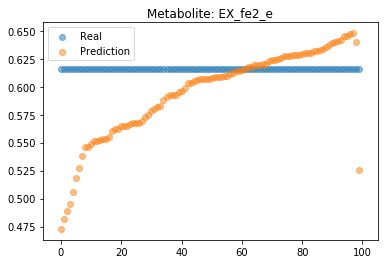

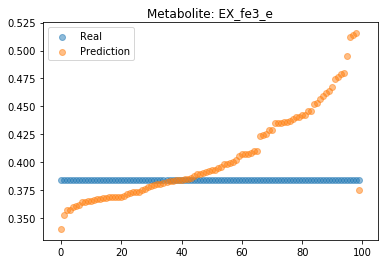

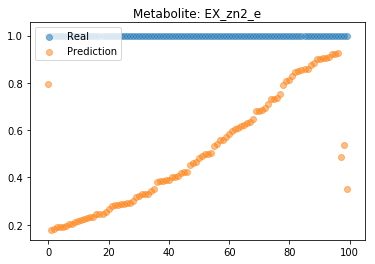

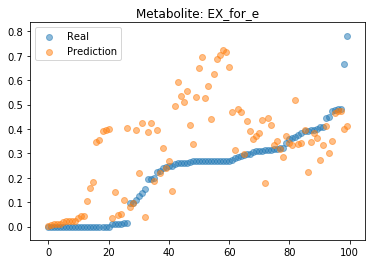

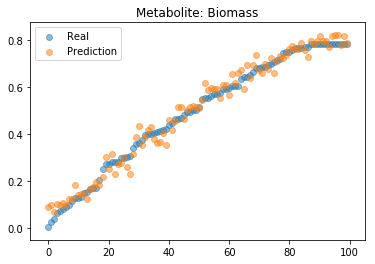

In [117]:
#Visualizing some predictions of the output metabolites 
for idx in range(outputsS.shape[1]):
    plot_prediction_comparison(predictionsS[:100,idx], norm_outputsS[:100,idx], fluxes_metabsS[idx])

In [118]:
train_prop = 0.8
val_prop = 0.1

x_trainS, x_valS, x_testS = divide_set(inputsS, train_prop, val_prop)
y_trainS, y_valS, y_testS = divide_set(norm_outputsS, train_prop, val_prop)
print('Input shape: ',x_trainS.shape)
print('Output shape: ',y_trainS.shape)

Input shape:  (4000, 24)
Output shape:  (4000, 25)


Train on 4000 samples, validate on 500 samples
Epoch 1/5
4000/4000 [==============================] - 1s 267us/sample - loss: 0.0127 - acc: 0.0590 - mean_absolute_error: 0.0566 - val_loss: 0.0036 - val_acc: 0.0780 - val_mean_absolute_error: 0.0306
Epoch 2/5
4000/4000 [==============================] - 0s 75us/sample - loss: 0.0035 - acc: 0.1252 - mean_absolute_error: 0.0283 - val_loss: 0.0033 - val_acc: 0.2000 - val_mean_absolute_error: 0.0264
Epoch 3/5
4000/4000 [==============================] - 0s 75us/sample - loss: 0.0033 - acc: 0.2122 - mean_absolute_error: 0.0262 - val_loss: 0.0032 - val_acc: 0.2300 - val_mean_absolute_error: 0.0252
Epoch 4/5
4000/4000 [==============================] - 0s 78us/sample - loss: 0.0031 - acc: 0.2048 - mean_absolute_error: 0.0249 - val_loss: 0.0031 - val_acc: 0.1860 - val_mean_absolute_error: 0.0243
Epoch 5/5
4000/4000 [==============================] - 0s 77us/sample - loss: 0.0031 - acc: 0.1570 - mean_absolute_error: 0.0240 - val_loss: 0.0030 - va

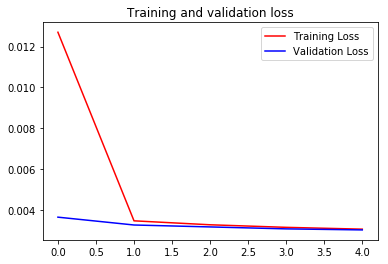

In [136]:
#Copying the model to test the transfer learning
model_transferS = copyKerasModel(model)
history = model_transferS.fit(x_trainS, y_trainS, epochs=5, verbose=1 , validation_data=(x_valS, y_valS))
plot_output(history, model_transferS)

In [137]:
print('\n# Evaluate on test data')
resultsS = model_transferS.evaluate(x_testS, y_testS)
print('test MSE, test acc, test MAE:', resultsS)

print('\n# Generate predictions')
predictionsS = model_transferS.predict(x_testS)
print('Biomass MAE: ', mean_absolute_error(y_testS[:,bioIdx],predictionsS[:,bioIdx]))


# Evaluate on test data
500/500 [==============================] - 0s 62us/sample - loss: 0.0031 - acc: 0.0980 - mean_absolute_error: 0.0239
test MSE, test acc, test MAE: [0.0031458110604435205, 0.098, 0.023944516]

# Generate predictions
Biomass MAE:  0.03492216575807078


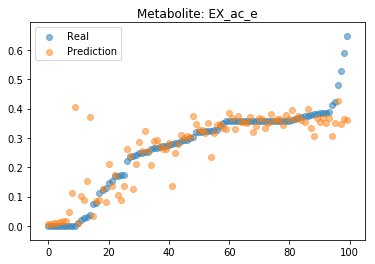

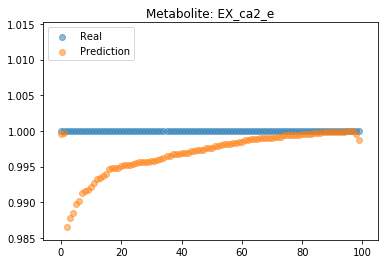

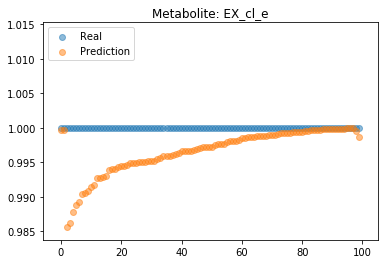

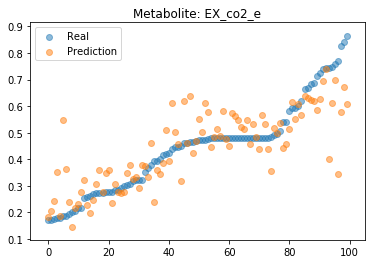

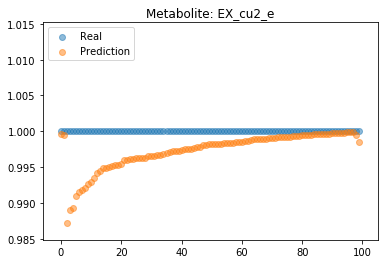

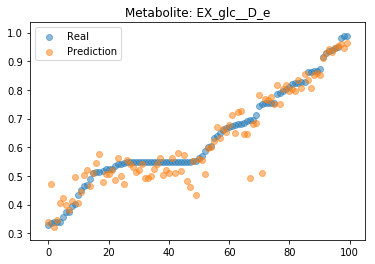

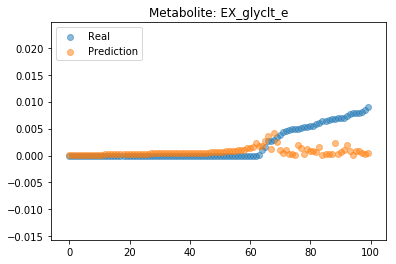

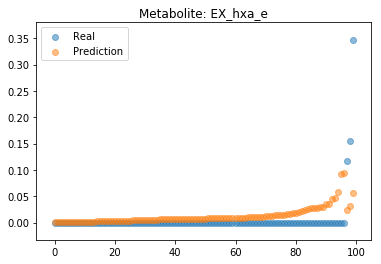

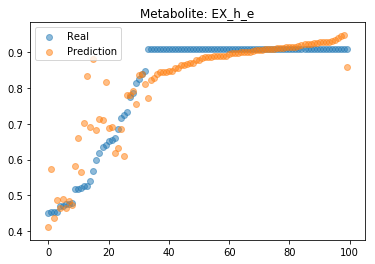

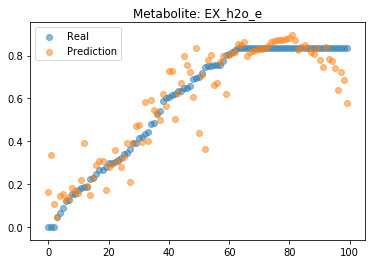

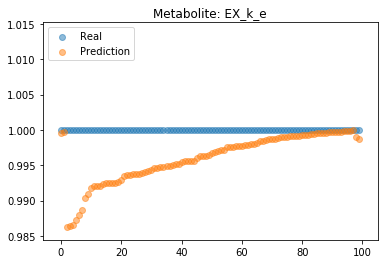

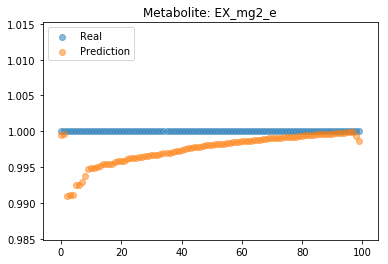

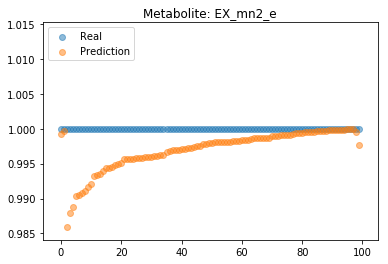

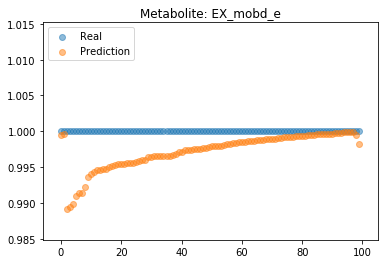

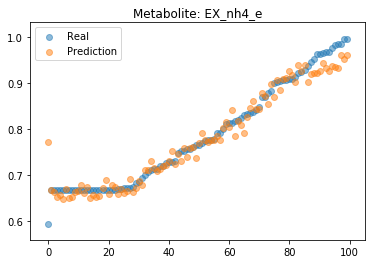

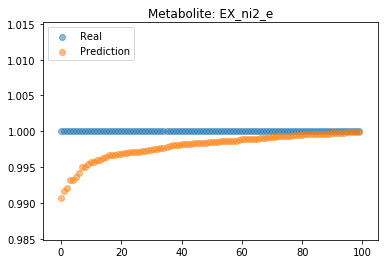

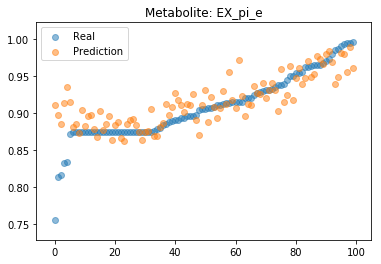

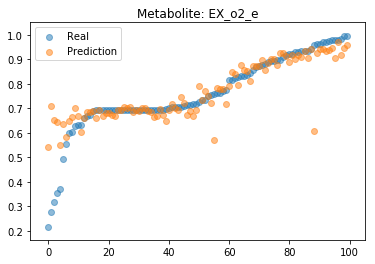

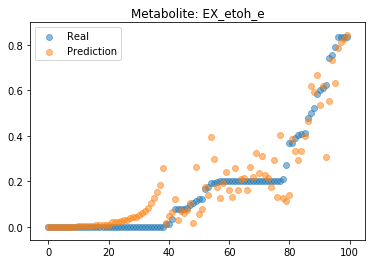

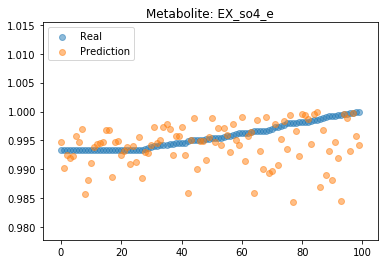

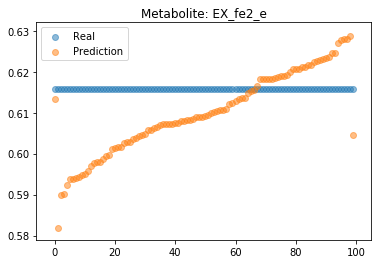

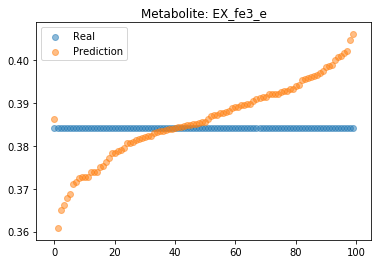

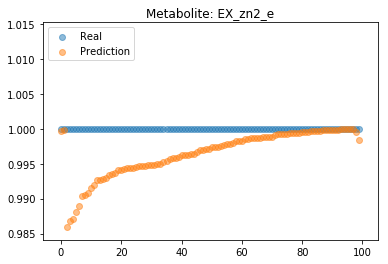

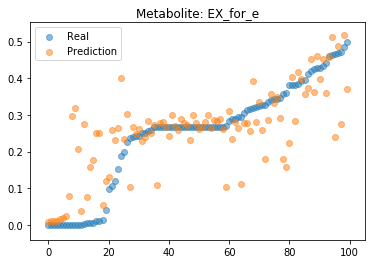

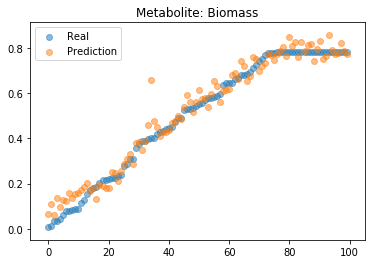

In [138]:
#Visualizing some predictions of the output metabolites 
for idx in range(outputsS.shape[1]):
    plot_prediction_comparison(predictionsS[:100,idx], y_testS[:100,idx], fluxes_metabsS[idx])

In [139]:
real_preds = norm2real(predictionsS, out_maxs, out_mins)
real_ytestS = norm2real(y_testS, out_maxs, out_mins)

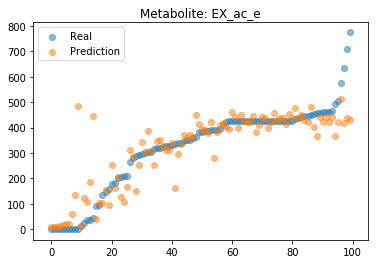

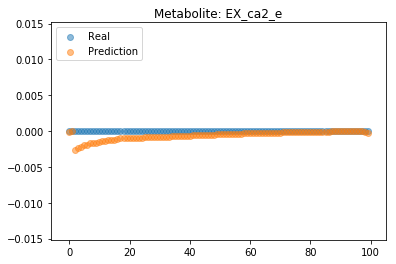

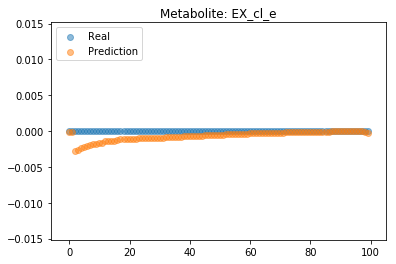

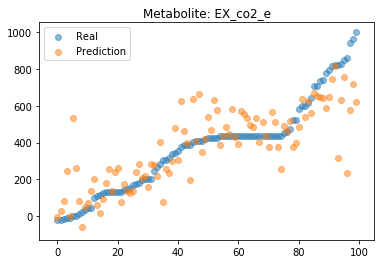

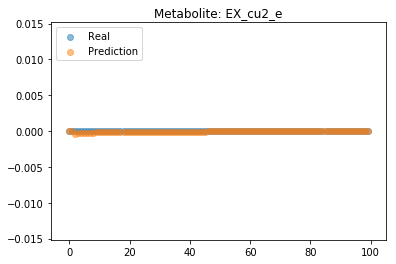

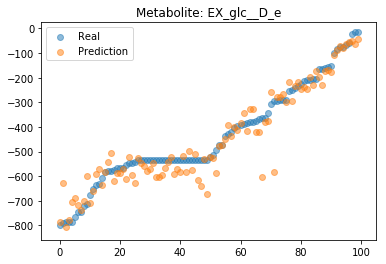

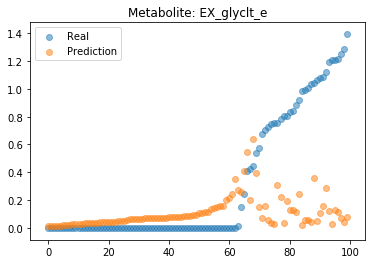

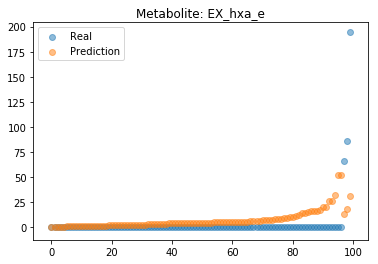

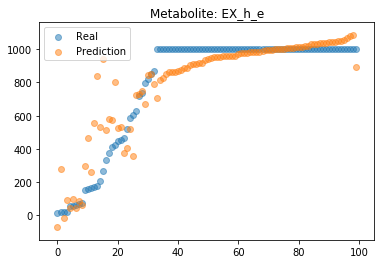

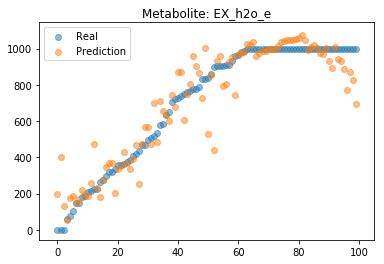

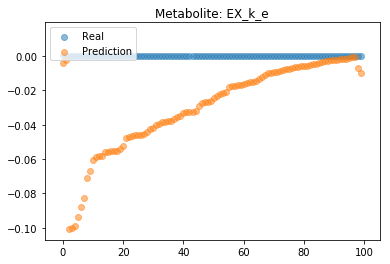

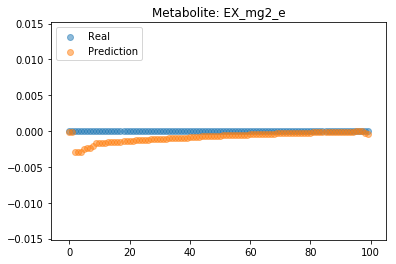

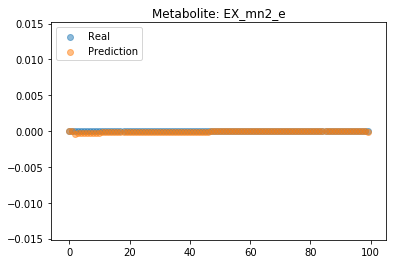

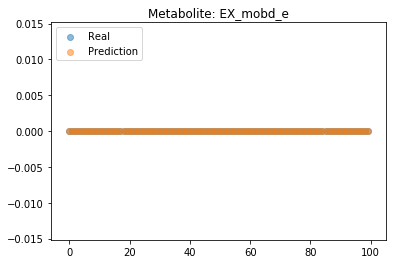

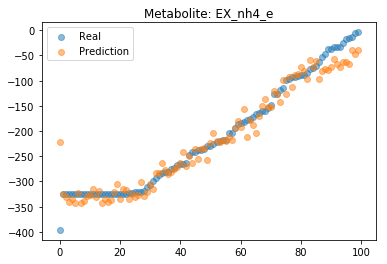

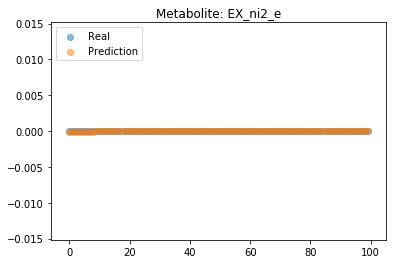

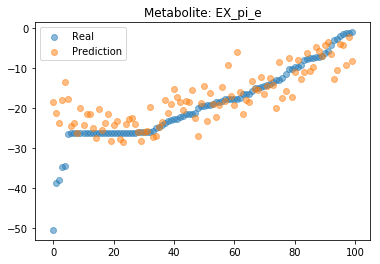

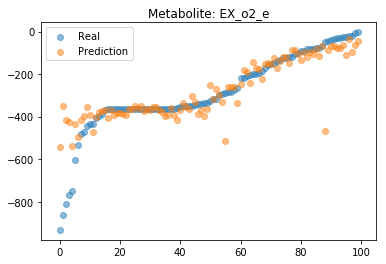

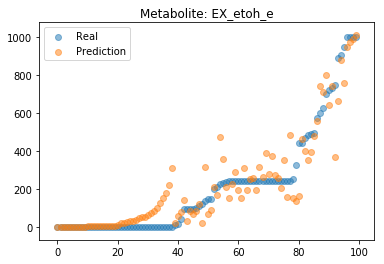

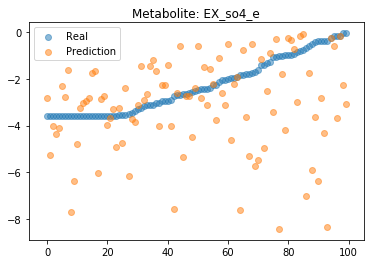

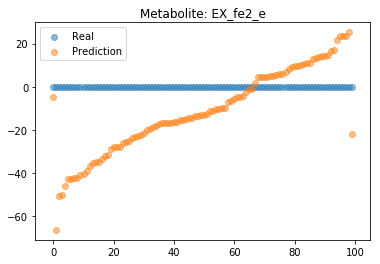

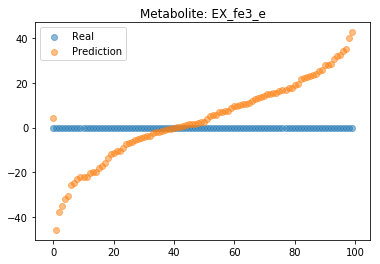

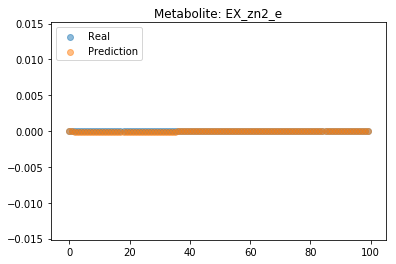

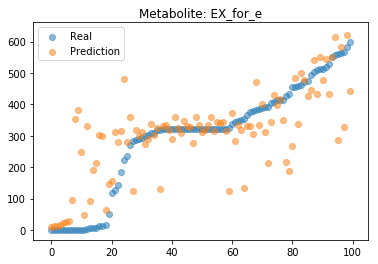

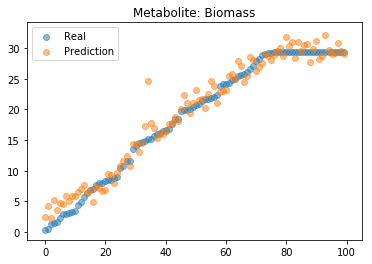

In [140]:
#Visualizing some predictions of the output metabolites 
for idx in range(outputsS.shape[1]):
    plot_prediction_comparison(real_preds[:100,idx], real_ytestS[:100,idx], fluxes_metabsS[idx])

In [142]:
real_ytestS

array([[ 3.88847985e+02,  0.00000000e+00,  2.77555756e-17, ...,
        -1.73472348e-18,  3.64838237e+02,  2.89054962e+01],
       [ 4.66789642e+02,  0.00000000e+00,  2.77555756e-17, ...,
        -1.73472348e-18,  3.02256567e+02,  2.71029659e+01],
       [ 0.00000000e+00,  0.00000000e+00,  2.77555756e-17, ...,
        -1.73472348e-18,  6.93094704e+00,  1.39165251e+00],
       ...,
       [ 4.27631064e+02,  0.00000000e+00,  2.77555756e-17, ...,
        -1.73472348e-18,  3.21890070e+02,  2.93942790e+01],
       [ 4.16545883e+02,  0.00000000e+00,  2.77555756e-17, ...,
        -1.73472348e-18,  6.08879267e+02,  5.97384891e+00],
       [ 3.92953502e+02,  0.00000000e+00,  2.77555756e-17, ...,
        -1.73472348e-18,  4.00945154e+02,  4.19782551e-01]])